<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/MNIST_Val_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/hamish-haggerty/base_rbt.git#egg='base_rbt'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hamish-haggerty/base_rbt.git to /tmp/pip-install-c5vh_c30/base-rbt_9c30348b842a4359aff70a4638256f0e
  Running command git clone -q https://github.com/hamish-haggerty/base_rbt.git /tmp/pip-install-c5vh_c30/base-rbt_9c30348b842a4359aff70a4638256f0e
     |████████████████████████████████| 551 kB 6.3 MB/s 
     |████████████████████████████████| 41 kB 51 kB/s 
     |████████████████████████████████| 549 kB 90.6 MB/s 
     |████████████████████████████████| 182 kB 103.7 MB/s 
  Created wheel for base-rbt: filename=base_rbt-0.0.1-py3-none-any.whl size=16049 sha256=482960ce079473e88e5641e2bb4b69b3d88bc341bd117125e2c1ae3050ea8168
  Stored in directory: /tmp/pip-ephem-wheel-cache-5k0xzj25/wheels/b3/25/be/8368facea57a956938db327bdd708e7f93ca5738de036e2c6e
Successfully built base-rbt


In [ ]:
from base_rbt.base_model import * 
from base_rbt.base_lf import *
from base_rbt.base_linear import *
from base_rbt.helper import *

In [ ]:
import self_supervised
import torch
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

How to test out the ensemble idea; We have several options. But why don't we actually try and get publishable results
first time around?

- For each ensemble, after training the encoders, fine tune on 10 valid sets (2 samples per class). Average results.

- Train 2-3 BT models as usual (separately). Baseline.
- Jointly train ensemble enforcing between representation redundancy reduction (i.e. correlation of zero constraint i.e. ~ make the representations independent.
- Train ensemble where one BT model gets one set of augmentations (half of them) and the other BT model gets the other half. So same as prior example except we partition the augmentations. Currently most bullish on this idea.

Question: Does it make sense for the representations to be independent? Wouldn't it make more sense, for them to just have high between group variance?
   
- Train ensemble and enforce high between representation variance; so since variables are normalized, have a term: $$ \mathcal{L} =  - \lVert z^{\tau_{1}} - z^{\tau_{2}} \rVert ^2$$. So instead of the representation being independent, they are just highly variable. This is a weaker(?) condition than them being independent.
    
Issue: How do we select the 't' hyperparameter? i.e. the amount of weight that we give to the new term.
Could do with =$[0.01,0.02,0.05,0.5]$ and just record the results. If best result comes from a boundary value then include more terms. Interesting in its own right.

If this works, we can do the same thing on maybe 2 other datasets, and this could be a paper. Also could do independence / correlation tests between the representations. Cool. 


So, say we have distribution of data augmentations $\tau_{1}$ and $\tau_{2}$, with $\tau = \tau_{1} \cup  \tau_{2}$ The key is in the comparison, and we want to make it fair, so:

- 1) Train 2 BT models on $\tau_{1}$ and $\tau_{2}$ respectively and ensemble. i.e. partition the augmentations.
- 2) Train 2 BT models on $\tau$ and ensemble. 
These are "baselines" but even if the first guy works better than the second guy, this is of independent interest.
- 3) Train joint ensembles, according to following 4 schemes:  
i) On $\tau$ and with RR OR HV   
ii) On $\tau_1$ and $\tau_2$ and with RR OR HV
    

So could have $\tau_{1} = [\text{blur,rotate}]$ and $\tau_{2} = [\text{solar,noise}]$. With some probability. They each have random flip, crop.


Results (fine tuning on 20 labelled examples after (ensemble) BT style pretraining. Repeated 10 times (for different 20 labelled examples) and results averaged):

1) mean=73.9629  
2) mean=69.53


So far looks like 3) ii) gives additional performance benefits beyond 1). 

Once MNIST results finished, test on one more dataset (with small amount of data)


Step 1): We need the data, and to set all the hps. 

In [ ]:
#hps's
device ='cuda' if torch.cuda.is_available() else 'cpu'
cuda = (device=='cuda')
seed=100 #Will have to try with different random seeds. Two times is probably enough 
n_in=1
indim=1024 #find this by inspection, e.g. for resnet18 is 1024
size=28
ps=1024 #Will also try with other values e.g. 125, 1000 etc
bs=128 #for training BT
bs_val=20 #for training linear head
bs_test=500 #divides 10000
ts_val=bs_val #but apparently we don't need it for current setting
ts=10*bs #since ensemble, want smaller amount of data

n_epochs=300 #epochs for BT 
numfit = 200 #epochs for linear classifer

In [ ]:
#Let's get MNIST data in a nicer way
path = untar_data(URLs.MNIST)
items = get_image_files(path/'training') #i.e. NOT testing!!!
items.sort()
seed_everything(seed=seed)
items=items.shuffle()
label_func=RegexLabeller(pat = r'/training/(\d)/')
labels = [label_func(i) for i in items]

items_train = items[0:ts] #train on ts samples
labels_train = labels[0:ts]
dls_train = ImageDataLoaders.from_lists(path,items_train, labels_train,bs=bs,
                                  valid_pct=0.0,num_workers=2*(device=='cuda'),device=device,item_tfms=[ToTensor()],
                                  img_cls=PILImageBW)
#items to select the tune_sets
items_tune = items[ts:ts+3000]
labels_tune = labels[ts:ts+3000]

#test set
label_func_test=RegexLabeller(pat = r'/testing/(\d)/')
items_test = get_image_files(path/'testing') #i.e. NOT testing!!!


labels_test = [label_func_test(i) for i in items_test]
dls_test = ImageDataLoaders.from_lists(path,items_test, labels_test,bs=bs_test,
                                  valid_pct=0.0,num_workers=2*(device=='cuda'),device=device,
                                  img_cls=PILImageBW
                                      )

def tune_set(items0,seed=42,IDs=None):

    seed_everything(seed=seed)
    items=items0.shuffle()
    raw=[]
    if IDs is None:
        IDs=[]
    items_tune20 = []
    labels_tune20 = []

    d = {'0':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0}

    for i in items:
        
   
        ID = i.name.strip('.png') #unique identifier
    
        label = label_func(i)
        if (d[label] == 0 or d[label] == 1) and (ID not in IDs):
            items_tune20.append(i)
            labels_tune20.append(label)
            d[label] += 1
            raw.append(i)
            IDs.append(ID)
            
        if len(raw)==20: #once we have 20 (unique!) guys we are done
            break
            

    dls_val = ImageDataLoaders.from_lists(path, items_tune20, labels_tune20,bs=20,
                                  valid_pct=0.0,num_workers=2*(device=='cuda'),device=device,
                                      img_cls=PILImageBW)

    d = {'items_tune20':items_tune20,'labels_tune20':labels_tune20,'raw':raw,'IDs':IDs,'dls_val':dls_val}
    
    return d


def get_unique_val_set(items0,seed,num=10):
    
    D={}
    IDs=[]
    
    for i in range(num):
        
        dls_val_dict = tune_set(items0,seed=seed+i,IDs=IDs)
        IDs = IDs + dls_val_dict['IDs']
        D[i] = dls_val_dict['dls_val']
    
    return D
        
    
DLS_VAL = get_unique_val_set(items_tune,seed=seed,num=10)

In [ ]:
#TODO: Write tests for tune_set and get_unique_val_set

In [ ]:
#Test dls_train, dls_val, dls_test and that function `tune_set` is working 

test_eq(seed,42)
test_eq(ts,10000)

x,y = dls_train.one_batch()
test_eq(x.shape, [bs, 1, 28, 28])

test_eq(len(dls_train.train_ds),ts)
test_eq(len(dls_test.train_ds),ts)

test_eq(len(dls_test.train)*bs_test,len(dls_test.train_ds))

_tune_set = tune_set(items_tune,seed=seed+1)
items_tune20,labels_tune20,dls_val,raw = _tune_set['items_tune20'],_tune_set['labels_tune20'], _tune_set['dls_val'],_tune_set['raw']


my_dict = {i:labels_tune20.count(i) for i in labels_tune20}
for i in my_dict.values():
    test_eq(i,2)

#test size
test_eq(len(dls_val.train),1)
test_eq(len(dls_val.train_ds),20)

#test random seed (please note that this depends on random seed chosen above to sort initially, i.e. seed=42)
_raw = tune_set(items_tune,seed=1)['raw']
test_eq(_raw[0].name,'28316.png')

_raw = tune_set(items_tune,seed=10)['raw']
test_eq(_raw[11].name,'11658.png')


New stuff we need to setup ensemble:

In [ ]:
class P4BarlowTwinsModel(Module):

    def __init__(self,encoder,encoder2,projector,projector2):
        self.encoder = encoder
        self.encoder2 = encoder2
        self.projector = projector
        self.projector2 = projector2
        
    def forward(self,x1,x2):
        
        #If we have multiple GPUs can take advantage of it here...
        tem,tem2 = self.encoder(x1),self.encoder2(x2)
        return self.projector(tem),self.projector2(tem2)

def create_p4barlow_twins_model(encoder,encoder2, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    
    projector2 = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector2)
    
    
    return P4BarlowTwinsModel(encoder,encoder2, projector,projector2)


In [ ]:
class BarlowTwinsEns(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines,n_in, lmb=5e-3, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        self.n_in=n_in
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)

    def before_batch(self):
        
        #TODO: Make this nicer (possibly can load in data as TensorImage(BW) or something?)
        #This is a bit of a hack. Can make this more elegant later. But in new version of FastAI
        #seems we need to compute TensorImage(BW) here, and depends on whether color or not, i.e. n_in.
        if self.n_in == 1:

            #Two distorted views according to first augmentation distribution
            xi,xj = self.aug1(TensorImageBW(self.x)), self.aug1(TensorImageBW(self.x))
            
            #Two distorted views according to second augmentation distribution
            xi_2,xj_2 = self.aug2(TensorImageBW(self.x)), self.aug2(TensorImageBW(self.x))

                                    
        elif self.n_in == 3:
            
            assert False
            
            xi,xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))
            
        
        self.learn.xb = (torch.cat([xi, xj]),torch.cat([xi_2, xj_2]))


    @torch.no_grad()
    def show(self, n=1):
        
        x=self.learn.x[0]
        y=self.learn.x[1]
        
        bs = x.size(0)//2
        x1,x2  = x[:bs], x[bs:]
        y1,y2  = y[:bs], y[bs:]
        
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug1.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        
        y1 = self.aug1.decode(y1[idxs].to('cpu').clone()).clamp(0,1)
        y2 = self.aug1.decode(y2[idxs].to('cpu').clone()).clamp(0,1)
        
        images = []
        for i in range(n): images += [x1[i],x2[i],y1[i],y2[i]]
        show_batch(x1[0], None, images, max_n=len(images), nrows=n)

        return


In [ ]:
def show_btens_batch(dls,n_in,aug,n=2,print_augs=True):
    "Given a linear learner, show a batch"
        
    learn = Learner(dls,model=None, cbs=[BarlowTwinsEns(aug,n_in=n_in,print_augs=print_augs)])
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')
    axes = learn.barlow_twins_ens.show(n=n)

In [ ]:
class AttributeDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
def lf_rbt_ens(pred,I,lmb,
               t,
               ):

    pred1 = pred[0]
    pred2 = pred[1]
    
    bs,nf = pred1.size(0)//2,pred1.size(1)

    #All standard, from BT
    z1, z2 = pred1[:bs],pred1[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
    
    z1_2, z2_2 = pred2[:bs],pred2[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm_2 = (z1_2 - z1_2.mean(0)) / (z1_2.std(0, unbiased=False) + 1e-7)
    z2norm_2 = (z2_2 - z2_2.mean(0)) / (z2_2.std(0, unbiased=False) + 1e-7)
    

    C = (z1norm.T @ z2norm) / bs 
    cdiff = (C - I)**2
    
    C = (z1norm_2.T @ z2norm_2) / bs 
    cdiff_2 = (C - I)**2
    
    C = (z1norm.T @ z1norm_2) / bs
    cdiff_inter = (C)**2
    
    l1 = (cdiff*I).sum() + lmb*(cdiff*(1-I)).sum()
    l2 = (cdiff_2*I).sum() + lmb*(cdiff_2*(1-I)).sum()
    
    l_inter = lmb*cdiff_inter.sum()
    
    #variance maximization: l_var = ...
    loss = (1-t)*(0.5*l1 + 0.5*l2) + (t)*l_inter

    torch.cuda.empty_cache()
    return loss

In [ ]:
# #Using RBT_enc
@patch
def lf(self:BarlowTwins, pred,*yb): return lf_rbt_ens(pred,I=self.I,lmb=self.lmb,hp=None)

Setup for linear evaluation:

In [ ]:
#Augmentation pipeline: just random resized crop and normalization
aug_pipelines_val=[get_linear_batch_augs(size=28,stats=mnist_stats,resize=True,resize_scale=(0.5, 1.0),resize_ratio=(3/4, 4/3))]

Optional: Show linear augmentations:

Pipeline: RandomResizedCrop -> Normalize -- {'mean': tensor([[[[0.1310]]]]), 'std': tensor([[[[0.3080]]]]), 'axes': (0, 2, 3)}
Pipeline: 


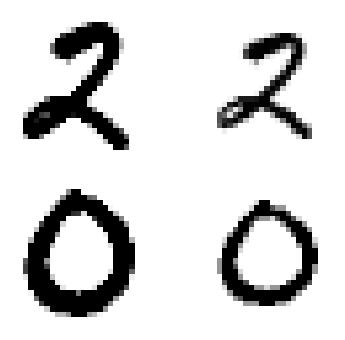

In [ ]:
#Use same dls each time so we can see how augmentation is varying
_dls = ImageDataLoaders.from_lists(path,items_train[0:2], labels_train[0:2],bs=2,
                                  valid_pct=0.0,num_workers=2*(device=='cuda'),device=device,item_tfms=[ToTensor()],
                                  img_cls=PILImageBW)

#The first column is the augmented view (fed to learner - i.e. linear model; second
#column is the un-augmented view.)
show_linear_batch(dls=_dls,n_in=n_in,n=2,aug=aug_pipelines_val,print_augs=True)

Example of augmentations for ensemble. Probably use these. 

In [ ]:

#tau1
aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=28,blur_r=(0.5,3),
                    rotate=True,jitter=False,noise=False,bw=False,blur=True,solar=False, #Whether to use aug or not
                    resize_scale=(0.5, 1.0),resize_ratio=(3/4, 4/3),noise_std=0.05, rotate_deg=45,blur_s=11,sol_t=0.025,sol_a=0.025, #hps of augs
                    flip_p=0.1, rotate_p=0.75,noise_p=0.75, jitter_p=0.3, bw_p=0.3, blur_p=0.5,sol_p=0.25, #prob of performing aug
                    same_on_batch=False,stats=mnist_stats, cuda=(device=='cuda'))


#tau2
aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=28,blur_r=(0.5,3),
                    rotate=False,jitter=False,noise=True,bw=False,blur=False,solar=True, #Whether to use aug or not
                    resize_scale=(0.5, 1.0),resize_ratio=(3/4, 4/3),noise_std=0.05, rotate_deg=45,blur_s=11,sol_t=0.025,sol_a=0.025, #hps of augs
                    flip_p=0.1, rotate_p=0.75,noise_p=0.75, jitter_p=0.3, bw_p=0.3, blur_p=0.5,sol_p=0.25, #prob of performing aug
                    same_on_batch=False,stats=mnist_stats, cuda=(device=='cuda'))

#"union" of 1 and 2 -> tau12
aug_pipelines_12 = get_barlow_twins_aug_pipelines(size=28,blur_r=(0.5,3),
                    rotate=True,jitter=False,noise=True,bw=False,blur=True,solar=True, #Whether to use aug or not
                    resize_scale=(0.5, 1.0),resize_ratio=(3/4, 4/3),noise_std=0.05, rotate_deg=45,blur_s=11,sol_t=0.025,sol_a=0.025, #hps of augs
                    flip_p=0.1, rotate_p=0.75,noise_p=0.75, jitter_p=0.3, bw_p=0.3, blur_p=0.5,sol_p=0.25, #prob of performing aug
                    same_on_batch=False,stats=mnist_stats, cuda=(device=='cuda'))


aug_pipelines = [aug_pipelines_12,aug_pipelines_12]

Step 3): (Optional): View the augmentations:

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.5, 's': 11, 'sig': None, 'blur_r': (0.5, 3), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.1310]]]]), 'std': tensor([[[[0.3080]]]]), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.5, 's': 11, 'sig': None, 'blur_r': (0.5, 3), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.1310]]]]), 'std': tensor([[[[0.3080]]]]), 'axes': (0, 2, 3)}


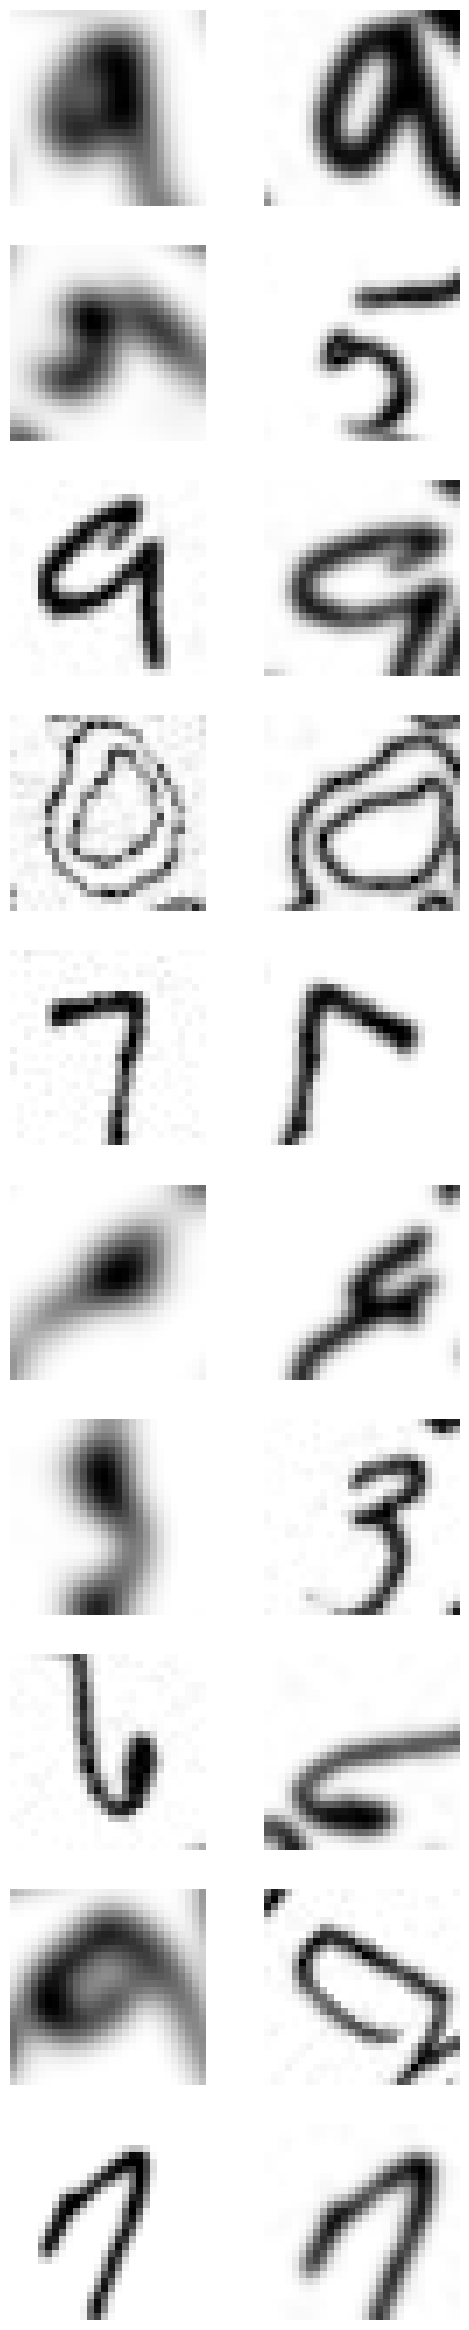

In [ ]:
#View the augmentations the "usual way"
show_bt_batch(dls=dls_train,n_in=n_in,aug=aug_pipelines,n=10,print_augs=True)

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.5, 's': 11, 'sig': None, 'blur_r': (0.5, 3), 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.1310]]]]), 'std': tensor([[[[0.3080]]]]), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianNoise -> RandomSolarize -> Normalize -- {'mean': tensor([[[[0.1310]]]]), 'std': tensor([[[[0.3080]]]]), 'axes': (0, 2, 3)}


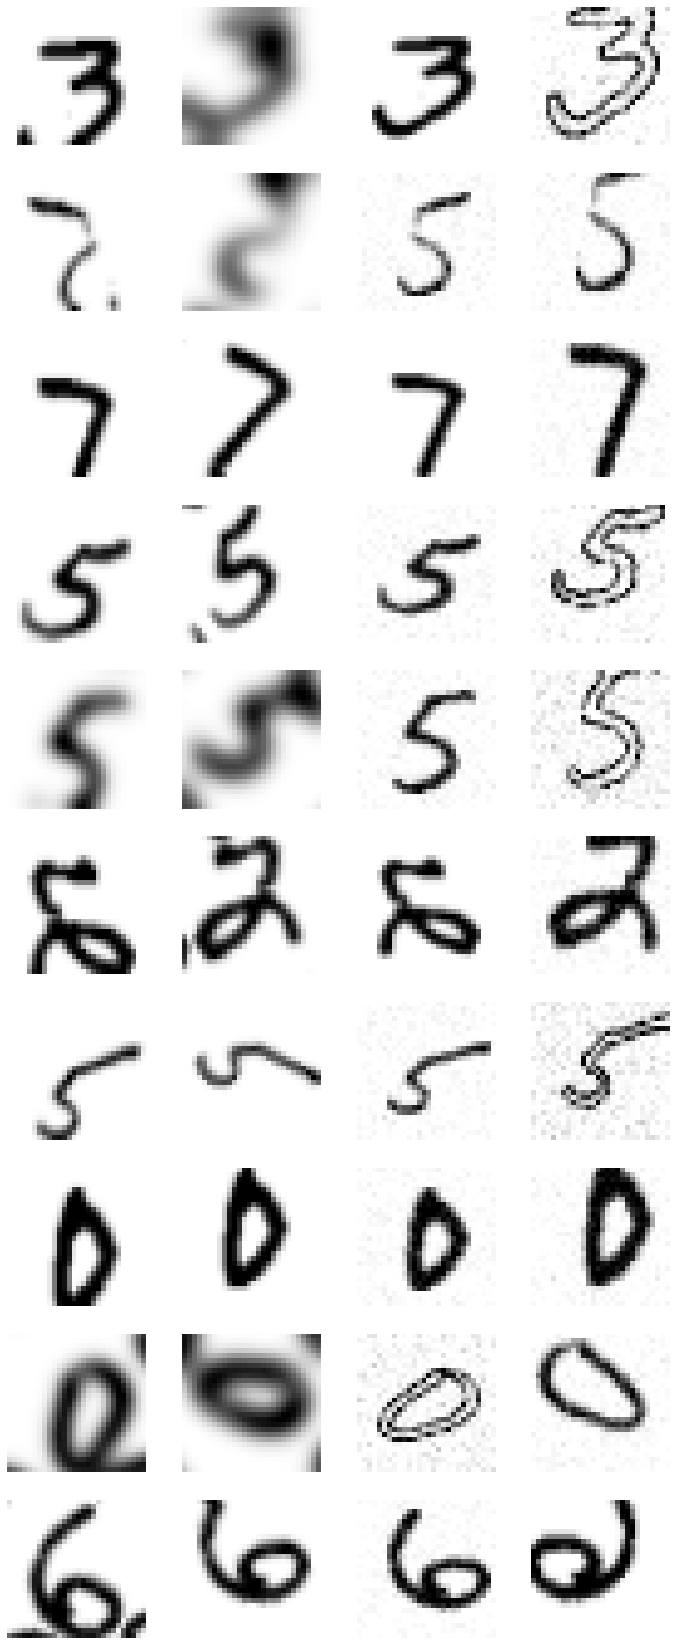

In [ ]:
#view the augmentations the 'ensemble' way
show_btens_batch(dls_train,n_in,aug=aug_pipelines,n=10,print_augs=True)

Next is stuff we need to train the ensembles:

In [ ]:
#train and evaluate ensemble of heads, given two fixed encoders
class Main_Linear_Ensemble_Eval(Main_Linear_Eval):
    def __init__(self,size,n_in,indim,numfit, #size e.g. 32, n_in e.g. 1 or 3, indim  is encoder output dim, numfit number of epochs training 
                 dls_val,dls_test, #dls_val for training linear, dls_test for evaluation
                 stats, #e.g. cifar_stats
                 aug_pipelines_val, #generally simple (crop and normalizatiom)
                 encoder,encoder_2
                ):
        
        super().__init__(size,n_in,indim,numfit, #size e.g. 32, n_in e.g. 1 or 3, indim  is encoder output dim, numfit number of epochs training 
                 dls_val,dls_test, #dls_val for training linear, dls_test for evaluation
                 stats, #e.g. cifar_stats
                 aug_pipelines_val,encoder)
        
        self.encoder_2 = encoder_2
        if self.encoder is not None:
            self.model_2 = LinearModel(encoder=self.encoder_2,indim=indim)
        
    #Eval_Model is the same as in Main_Linear_Eval
    
    #We need to rewrite this guy to take in two models now (average predictions)
    def eval_linear(self):

        eval_model = self.Eval_Mode(self.model)
        eval_model_2 = self.Eval_Mode(self.model_2)
        
        N=len(self.dls_test.train)*self.dls_test.bs
        test_eq(N,len(self.dls_test.train_ds)) #check that batch size divides length of test set
        
        num_correct=0
        for x,y in self.dls_test.train:

            ypred = 0.5*eval_model(x)  + 0.5*eval_model_2(x)

            correct = (torch.argmax(ypred,dim=1) == y).type(torch.FloatTensor)
            num_correct += correct.sum()

        accuracy = num_correct/N
        return accuracy.item()
    
    def __call__(self):
        
        #train linear classifier on dls_eval. Requires inputs: encoder, aug_pipeline, dls, 
        bt = LinearBt(self.aug_pipelines_val,show_batch=True,n_in=self.n_in,print_augs=False)
        learn = Learner(self.dls_val,self.model, cbs=[bt])
        learn.fit(self.numfit)
        
        bt_2 = LinearBt(self.aug_pipelines_val,show_batch=True,n_in=self.n_in,print_augs=False)
        learn_2 = Learner(self.dls_val,self.model_2, cbs=[bt_2])
        learn_2.fit(self.numfit)
        
        #eval linear classifier
        acc = self.eval_linear() #Is now average
        
        return acc

In [ ]:
#Train the encoders; depends on t (amount of weight to give to new term)
#and the augmentation pipeline
def train_rbt(t,aug_pipelines):
        
    @patch
    def lf(self:BarlowTwinsEns, pred,*yb): return lf_rbt_ens(pred,I=self.I,lmb=self.lmb,t=t) #pass them to loss function
  
    #train
    fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
    fastai_encoder_2 = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)

    model = create_p4barlow_twins_model(fastai_encoder,fastai_encoder_2, hidden_size=ps,projection_size=ps,nlayers=3)
    learn = Learner(dls_train,model, cbs=[BarlowTwinsEns(aug_pipelines,n_in=n_in,lmb=1/ps,print_augs=False)])
    learn.fit(n_epochs)

    return fastai_encoder,fastai_encoder_2


In [ ]:
#Evaluate the encoders by tuning on several tune-valid sets and then testing on test set
def tune_valid(fastai_encoder,fastai_encoder_2,DLS_VAL=None):
    fastai_encoder.eval() #eval mode
    fastai_encoder = grad_on(fastai_encoder,on=False) #turn off gradients
    
    fastai_encoder_2.eval() #eval mode
    fastai_encoder_2 = grad_on(fastai_encoder_2,on=False) #turn off gradients
    
    N=len(DLS_VAL)
    acc_dict={}
    for i in range(N):
        
        #dls_val = tune_set(items_tune,seed=seed+i)['dls_val']
        dls_val=DLS_VAL[i]
        
        main_linear_eval = Main_Linear_Ensemble_Eval(size=size,n_in=n_in,numfit=numfit,indim=1024, #size,n_in=3 (color channels),number of epochs to fit linear, and output dimension of encoder
                                dls_val=dls_val,dls_test=dls_test, #dls for training linear and evaluating linear
                                stats=mnist_stats,
                                aug_pipelines_val=aug_pipelines_val, #aug_pipeline for training 
                                encoder=fastai_encoder,
                                encoder_2=fastai_encoder_2
                                            )
                
        #main_linear_eval.encoder = self.encoder (usage within BT training)
        acc=main_linear_eval()
        
        acc_dict[i]=acc
        
    acc_dict['mean'] = (sum(list(acc_dict.values()))/len(acc_dict.values()))
    #print((sum(list(acc_dict.values()))/len(acc_dict.values())))
    
    return acc_dict

Here is the entire API for training our ensemble:

In [ ]:
#Hyperparameters: 
#               - value of t (weight to new term);

t = [0.25,0.1,0.05,0.01]

#               -augmentations: (tau1,tau2) or (tau12,tau12)
augs = ['disjoint','union']
hp_vals = [t,augs]
hp_vals = itertools.product(*hp_vals)
               
def train_RBT_ensemble(hp,_augs='disjoint',DLS_VAL=None):

    if _augs=='disjoint':
        aug_pipelines = [aug_pipelines_1,aug_pipelines_2] #choice here

    elif _augs=='union':
        aug_pipelines = [aug_pipelines_12,aug_pipelines_12]

    fastai_encoder,fastai_encoder_2=train_rbt(hp,aug_pipelines) #train ensemble

    acc_dict=tune_valid(fastai_encoder,fastai_encoder_2,DLS_VAL=DLS_VAL) #train and evaluate ensemble of heads
    
    return acc_dict

if __name__ == '__main__':
    RBT_ENSEMBLE = {}
    for hp in hp_vals:
        acc_dict = train_RBT_ensemble(hp[0],_augs='disjoint',DLS_VAL=DLS_VAL)
        RBT_ENSEMBLE[hp] = acc_dict
        print(f"With hps {hp} total results are {acc_dict} with mean {acc_dict['mean']}") #print out results as we go

    for hp_vals in RBT_ENSEMBLE.keys():
        print(f"With hps {hp} total results are {RBT_ENSEMBLE[hp]} with mean {RBT_ENSEMBLE[hp]['mean']}\n") #print out final results 

RBT_ENSEMBLE #Display final results

    


epoch,train_loss,valid_loss,time
0,358.273254,None,00:09
1,286.069824,None,00:01
2,256.424774,None,00:01
3,236.926056,None,00:01
4,219.525009,None,00:01
5,205.492950,None,00:01
6,195.051529,None,00:01
7,183.877930,None,00:01
8,173.721268,None,00:01
9,164.118835,None,00:01


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.496427,None,00:00
1,2.354587,None,00:00
2,2.213492,None,00:00
3,2.079056,None,00:00
4,1.958085,None,00:00
5,1.845565,None,00:00
6,1.738395,None,00:00
7,1.646127,None,00:00
8,1.566070,None,00:00
9,1.488678,None,00:00


epoch,train_loss,valid_loss,time
0,2.440115,None,00:00
1,2.259115,None,00:00
2,2.102514,None,00:00
3,1.971329,None,00:00
4,1.828653,None,00:00
5,1.697054,None,00:00
6,1.612696,None,00:00
7,1.499512,None,00:00
8,1.394791,None,00:00
9,1.300731,None,00:00


epoch,train_loss,valid_loss,time
0,2.407286,None,00:00
1,2.248405,None,00:00
2,2.094311,None,00:00
3,1.958360,None,00:00
4,1.837447,None,00:00
5,1.713248,None,00:00
6,1.604654,None,00:00
7,1.523212,None,00:00
8,1.424996,None,00:00
9,1.346724,None,00:00


epoch,train_loss,valid_loss,time
0,2.337606,None,00:00
1,2.155198,None,00:00
2,1.983685,None,00:00
3,1.838394,None,00:00
4,1.690977,None,00:00
5,1.555670,None,00:00
6,1.442113,None,00:00
7,1.328213,None,00:00
8,1.225286,None,00:00
9,1.133520,None,00:00


epoch,train_loss,valid_loss,time
0,2.443607,None,00:00
1,2.296443,None,00:00
2,2.154324,None,00:00
3,2.024810,None,00:00
4,1.899781,None,00:00
5,1.800515,None,00:00
6,1.696484,None,00:00
7,1.598446,None,00:00
8,1.508294,None,00:00
9,1.432562,None,00:00


epoch,train_loss,valid_loss,time
0,2.361927,None,00:00
1,2.199866,None,00:00
2,2.045740,None,00:00
3,1.888720,None,00:00
4,1.740727,None,00:00
5,1.605333,None,00:00
6,1.483592,None,00:00
7,1.375647,None,00:00
8,1.287252,None,00:00
9,1.194578,None,00:00


epoch,train_loss,valid_loss,time
0,2.414762,None,00:00
1,2.250566,None,00:00
2,2.102995,None,00:00
3,1.969148,None,00:00
4,1.839522,None,00:00
5,1.728406,None,00:00
6,1.619886,None,00:00
7,1.524637,None,00:00
8,1.435812,None,00:00
9,1.373156,None,00:00


epoch,train_loss,valid_loss,time
0,2.353606,None,00:00
1,2.180583,None,00:00
2,2.030166,None,00:00
3,1.890186,None,00:00
4,1.745506,None,00:00
5,1.613101,None,00:00
6,1.509679,None,00:00
7,1.396902,None,00:00
8,1.299592,None,00:00
9,1.206640,None,00:00


epoch,train_loss,valid_loss,time
0,2.385832,None,00:00
1,2.213037,None,00:00
2,2.072137,None,00:00
3,1.936014,None,00:00
4,1.825899,None,00:00
5,1.711452,None,00:00
6,1.610288,None,00:00
7,1.515923,None,00:00
8,1.431056,None,00:00
9,1.359142,None,00:00


epoch,train_loss,valid_loss,time
0,2.380578,None,00:00
1,2.213230,None,00:00
2,2.047088,None,00:00
3,1.903228,None,00:00
4,1.750892,None,00:00
5,1.614371,None,00:00
6,1.487409,None,00:00
7,1.373509,None,00:00
8,1.271774,None,00:00
9,1.181280,None,00:00


epoch,train_loss,valid_loss,time
0,2.428106,None,00:00
1,2.296475,None,00:00
2,2.159580,None,00:00
3,2.026611,None,00:00
4,1.916587,None,00:00
5,1.812546,None,00:00
6,1.711949,None,00:00
7,1.623026,None,00:00
8,1.536304,None,00:00
9,1.458032,None,00:00


epoch,train_loss,valid_loss,time
0,2.250566,None,00:00
1,2.100707,None,00:00
2,1.950280,None,00:00
3,1.801248,None,00:00
4,1.671199,None,00:00
5,1.541344,None,00:00
6,1.425818,None,00:00
7,1.321489,None,00:00
8,1.222827,None,00:00
9,1.137209,None,00:00


epoch,train_loss,valid_loss,time
0,2.268646,None,00:00
1,2.111482,None,00:00
2,2.009253,None,00:00
3,1.884856,None,00:00
4,1.777507,None,00:00
5,1.690833,None,00:00
6,1.599850,None,00:00
7,1.518249,None,00:00
8,1.438980,None,00:00
9,1.363037,None,00:00


epoch,train_loss,valid_loss,time
0,2.273444,None,00:00
1,2.113116,None,00:00
2,1.937028,None,00:00
3,1.796488,None,00:00
4,1.664410,None,00:00
5,1.535104,None,00:00
6,1.411752,None,00:00
7,1.300022,None,00:00
8,1.200185,None,00:00
9,1.109748,None,00:00


epoch,train_loss,valid_loss,time
0,2.329477,None,00:00
1,2.186899,None,00:00
2,2.060857,None,00:00
3,1.933528,None,00:00
4,1.838164,None,00:00
5,1.729462,None,00:00
6,1.643781,None,00:00
7,1.556978,None,00:00
8,1.472976,None,00:00
9,1.396635,None,00:00


epoch,train_loss,valid_loss,time
0,2.236125,None,00:00
1,2.055928,None,00:00
2,1.901274,None,00:00
3,1.754738,None,00:00
4,1.619308,None,00:00
5,1.491447,None,00:00
6,1.376382,None,00:00
7,1.268692,None,00:00
8,1.174833,None,00:00
9,1.088236,None,00:00


epoch,train_loss,valid_loss,time
0,2.445008,None,00:00
1,2.283024,None,00:00
2,2.120192,None,00:00
3,1.963891,None,00:00
4,1.821560,None,00:00
5,1.695417,None,00:00
6,1.582856,None,00:00
7,1.487551,None,00:00
8,1.392059,None,00:00
9,1.310515,None,00:00


epoch,train_loss,valid_loss,time
0,2.392939,None,00:00
1,2.194309,None,00:00
2,1.999141,None,00:00
3,1.826239,None,00:00
4,1.669601,None,00:00
5,1.524092,None,00:00
6,1.391657,None,00:00
7,1.271016,None,00:00
8,1.166263,None,00:00
9,1.071543,None,00:00


epoch,train_loss,valid_loss,time
0,2.501433,None,00:00
1,2.335650,None,00:00
2,2.182854,None,00:00
3,2.048105,None,00:00
4,1.922965,None,00:00
5,1.802904,None,00:00
6,1.706035,None,00:00
7,1.626212,None,00:00
8,1.536263,None,00:00
9,1.454368,None,00:00


epoch,train_loss,valid_loss,time
0,2.333755,None,00:00
1,2.174043,None,00:00
2,2.036125,None,00:00
3,1.883589,None,00:00
4,1.733437,None,00:00
5,1.602256,None,00:00
6,1.481033,None,00:00
7,1.369947,None,00:00
8,1.267008,None,00:00
9,1.174954,None,00:00


With hps (0.25, 'disjoint') total results are {0: 0.6693000197410583, 1: 0.7365999817848206, 2: 0.7627999782562256, 3: 0.6904000043869019, 4: 0.7419999837875366, 5: 0.743399977684021, 6: 0.7409999966621399, 7: 0.707099974155426, 8: 0.6729999780654907, 9: 0.7026000022888184, 'mean': 0.7168199896812439} with mean 0.7168199896812439


epoch,train_loss,valid_loss,time
0,369.696320,None,00:01
1,299.670868,None,00:01
2,259.546143,None,00:01
3,234.567261,None,00:01
4,216.108597,None,00:01
5,203.264893,None,00:01
6,192.402405,None,00:01
7,182.253860,None,00:01
8,172.843719,None,00:01
9,163.537704,None,00:01


epoch,train_loss,valid_loss,time
0,2.219949,None,00:00
1,2.074573,None,00:00
2,1.938236,None,00:00
3,1.821262,None,00:00
4,1.713259,None,00:00
5,1.616224,None,00:00
6,1.531578,None,00:00
7,1.448844,None,00:00
8,1.375980,None,00:00
9,1.309172,None,00:00


epoch,train_loss,valid_loss,time
0,2.467402,None,00:00
1,2.295846,None,00:00
2,2.134223,None,00:00
3,1.976297,None,00:00
4,1.829750,None,00:00
5,1.702561,None,00:00
6,1.584814,None,00:00
7,1.471252,None,00:00
8,1.369351,None,00:00
9,1.275247,None,00:00


epoch,train_loss,valid_loss,time
0,2.182448,None,00:00
1,2.037382,None,00:00
2,1.899756,None,00:00
3,1.767885,None,00:00
4,1.672907,None,00:00
5,1.574700,None,00:00
6,1.477345,None,00:00
7,1.392072,None,00:00
8,1.321875,None,00:00
9,1.249425,None,00:00


epoch,train_loss,valid_loss,time
0,2.328240,None,00:00
1,2.151345,None,00:00
2,1.980324,None,00:00
3,1.824265,None,00:00
4,1.674652,None,00:00
5,1.537893,None,00:00
6,1.421665,None,00:00
7,1.308232,None,00:00
8,1.209776,None,00:00
9,1.124580,None,00:00


epoch,train_loss,valid_loss,time
0,2.453764,None,00:00
1,2.297863,None,00:00
2,2.154087,None,00:00
3,2.025165,None,00:00
4,1.898891,None,00:00
5,1.783649,None,00:00
6,1.695930,None,00:00
7,1.595307,None,00:00
8,1.511559,None,00:00
9,1.433764,None,00:00


epoch,train_loss,valid_loss,time
0,2.338522,None,00:00
1,2.170309,None,00:00
2,2.010230,None,00:00
3,1.853880,None,00:00
4,1.709616,None,00:00
5,1.583000,None,00:00
6,1.459847,None,00:00
7,1.350986,None,00:00
8,1.253391,None,00:00
9,1.174420,None,00:00


epoch,train_loss,valid_loss,time
0,2.208197,None,00:00
1,2.058111,None,00:00
2,1.914804,None,00:00
3,1.831870,None,00:00
4,1.711276,None,00:00
5,1.609925,None,00:00
6,1.523681,None,00:00
7,1.443182,None,00:00
8,1.360996,None,00:00
9,1.287845,None,00:00


epoch,train_loss,valid_loss,time
0,2.459404,None,00:00
1,2.293074,None,00:00
2,2.123431,None,00:00
3,1.969503,None,00:00
4,1.814050,None,00:00
5,1.681927,None,00:00
6,1.560341,None,00:00
7,1.442910,None,00:00
8,1.336216,None,00:00
9,1.239837,None,00:00


epoch,train_loss,valid_loss,time
0,2.330702,None,00:00
1,2.184289,None,00:00
2,2.055265,None,00:00
3,1.957420,None,00:00
4,1.833889,None,00:00
5,1.728332,None,00:00
6,1.626106,None,00:00
7,1.534720,None,00:00
8,1.451242,None,00:00
9,1.377372,None,00:00


epoch,train_loss,valid_loss,time
0,2.332935,None,00:00
1,2.155998,None,00:00
2,2.013416,None,00:00
3,1.851999,None,00:00
4,1.714106,None,00:00
5,1.580121,None,00:00
6,1.464674,None,00:00
7,1.354297,None,00:00
8,1.251351,None,00:00
9,1.165724,None,00:00


epoch,train_loss,valid_loss,time
0,2.487687,None,00:00
1,2.328253,None,00:00
2,2.182209,None,00:00
3,2.057328,None,00:00
4,1.946031,None,00:00
5,1.835291,None,00:00
6,1.738279,None,00:00
7,1.669092,None,00:00
8,1.582710,None,00:00
9,1.509120,None,00:00


epoch,train_loss,valid_loss,time
0,2.411151,None,00:00
1,2.227592,None,00:00
2,2.070428,None,00:00
3,1.914331,None,00:00
4,1.763363,None,00:00
5,1.642375,None,00:00
6,1.513554,None,00:00
7,1.399535,None,00:00
8,1.294642,None,00:00
9,1.201703,None,00:00


epoch,train_loss,valid_loss,time
0,2.382486,None,00:00
1,2.243193,None,00:00
2,2.098122,None,00:00
3,1.981486,None,00:00
4,1.896965,None,00:00
5,1.785089,None,00:00
6,1.688322,None,00:00
7,1.593827,None,00:00
8,1.509455,None,00:00
9,1.430694,None,00:00


epoch,train_loss,valid_loss,time
0,2.459486,None,00:00
1,2.278674,None,00:00
2,2.107423,None,00:00
3,1.942431,None,00:00
4,1.794666,None,00:00
5,1.649575,None,00:00
6,1.519612,None,00:00
7,1.399732,None,00:00
8,1.291508,None,00:00
9,1.192738,None,00:00


epoch,train_loss,valid_loss,time
0,2.335135,None,00:00
1,2.215879,None,00:00
2,2.087556,None,00:00
3,1.955956,None,00:00
4,1.834503,None,00:00
5,1.739155,None,00:00
6,1.641542,None,00:00
7,1.547428,None,00:00
8,1.466588,None,00:00
9,1.395667,None,00:00


epoch,train_loss,valid_loss,time
0,2.468324,None,00:00
1,2.284228,None,00:00
2,2.119335,None,00:00
3,1.969397,None,00:00
4,1.819319,None,00:00
5,1.684994,None,00:00
6,1.564644,None,00:00
7,1.445938,None,00:00
8,1.345835,None,00:00
9,1.248749,None,00:00


epoch,train_loss,valid_loss,time
0,2.395048,None,00:00
1,2.218877,None,00:00
2,2.082761,None,00:00
3,1.952719,None,00:00
4,1.827216,None,00:00
5,1.707412,None,00:00
6,1.610355,None,00:00
7,1.509459,None,00:00
8,1.425957,None,00:00
9,1.345439,None,00:00


epoch,train_loss,valid_loss,time
0,2.332849,None,00:00
1,2.141415,None,00:00
2,1.963516,None,00:00
3,1.791940,None,00:00
4,1.638204,None,00:00
5,1.493444,None,00:00
6,1.375333,None,00:00
7,1.257136,None,00:00
8,1.155215,None,00:00
9,1.061742,None,00:00


epoch,train_loss,valid_loss,time
0,2.322191,None,00:00
1,2.166831,None,00:00
2,2.019822,None,00:00
3,1.910760,None,00:00
4,1.790180,None,00:00
5,1.684642,None,00:00
6,1.595377,None,00:00
7,1.505522,None,00:00
8,1.425029,None,00:00
9,1.351213,None,00:00


epoch,train_loss,valid_loss,time
0,2.288823,None,00:00
1,2.137247,None,00:00
2,1.975547,None,00:00
3,1.816018,None,00:00
4,1.673735,None,00:00
5,1.543344,None,00:00
6,1.426130,None,00:00
7,1.315846,None,00:00
8,1.220375,None,00:00
9,1.143996,None,00:00


With hps (0.25, 'union') total results are {0: 0.661300003528595, 1: 0.7418000102043152, 2: 0.7511000037193298, 3: 0.6898999810218811, 4: 0.7404999732971191, 5: 0.718999981880188, 6: 0.7671999931335449, 7: 0.715499997138977, 8: 0.6425999999046326, 9: 0.6883999705314636, 'mean': 0.7117299914360047} with mean 0.7117299914360047


epoch,train_loss,valid_loss,time
0,431.506866,None,00:01
1,350.621399,None,00:01
2,303.808167,None,00:01
3,271.696503,None,00:01
4,248.304764,None,00:01
5,229.480087,None,00:01
6,215.750488,None,00:01
7,203.492508,None,00:01
8,194.669754,None,00:01
9,186.692505,None,00:01


epoch,train_loss,valid_loss,time
0,2.247118,None,00:00
1,2.091377,None,00:00
2,1.943562,None,00:00
3,1.806657,None,00:00
4,1.688380,None,00:00
5,1.577407,None,00:00
6,1.477906,None,00:00
7,1.404321,None,00:00
8,1.320110,None,00:00
9,1.243480,None,00:00


epoch,train_loss,valid_loss,time
0,2.412069,None,00:00
1,2.254544,None,00:00
2,2.116969,None,00:00
3,1.962794,None,00:00
4,1.821663,None,00:00
5,1.695544,None,00:00
6,1.570704,None,00:00
7,1.457031,None,00:00
8,1.359282,None,00:00
9,1.264264,None,00:00


epoch,train_loss,valid_loss,time
0,2.405667,None,00:00
1,2.228877,None,00:00
2,2.068871,None,00:00
3,1.919986,None,00:00
4,1.788786,None,00:00
5,1.663471,None,00:00
6,1.560678,None,00:00
7,1.453561,None,00:00
8,1.356946,None,00:00
9,1.267686,None,00:00


epoch,train_loss,valid_loss,time
0,2.357737,None,00:00
1,2.178221,None,00:00
2,2.008231,None,00:00
3,1.854053,None,00:00
4,1.708883,None,00:00
5,1.585006,None,00:00
6,1.462785,None,00:00
7,1.350177,None,00:00
8,1.248617,None,00:00
9,1.157020,None,00:00


epoch,train_loss,valid_loss,time
0,2.340462,None,00:00
1,2.173940,None,00:00
2,2.017799,None,00:00
3,1.899494,None,00:00
4,1.762490,None,00:00
5,1.667498,None,00:00
6,1.555880,None,00:00
7,1.458430,None,00:00
8,1.373391,None,00:00
9,1.289527,None,00:00


epoch,train_loss,valid_loss,time
0,2.526716,None,00:00
1,2.356513,None,00:00
2,2.217559,None,00:00
3,2.040389,None,00:00
4,1.884305,None,00:00
5,1.762772,None,00:00
6,1.629371,None,00:00
7,1.509872,None,00:00
8,1.403677,None,00:00
9,1.307371,None,00:00


epoch,train_loss,valid_loss,time
0,2.498859,None,00:00
1,2.347322,None,00:00
2,2.220820,None,00:00
3,2.091739,None,00:00
4,1.941619,None,00:00
5,1.808768,None,00:00
6,1.715360,None,00:00
7,1.609369,None,00:00
8,1.508546,None,00:00
9,1.435292,None,00:00


epoch,train_loss,valid_loss,time
0,2.409251,None,00:00
1,2.233437,None,00:00
2,2.065522,None,00:00
3,1.914113,None,00:00
4,1.768282,None,00:00
5,1.630089,None,00:00
6,1.504024,None,00:00
7,1.392245,None,00:00
8,1.288066,None,00:00
9,1.193308,None,00:00


epoch,train_loss,valid_loss,time
0,2.278515,None,00:00
1,2.140242,None,00:00
2,1.991364,None,00:00
3,1.852209,None,00:00
4,1.726866,None,00:00
5,1.617823,None,00:00
6,1.510928,None,00:00
7,1.417127,None,00:00
8,1.328125,None,00:00
9,1.250898,None,00:00


epoch,train_loss,valid_loss,time
0,2.391456,None,00:00
1,2.208300,None,00:00
2,2.049474,None,00:00
3,1.886264,None,00:00
4,1.742473,None,00:00
5,1.609101,None,00:00
6,1.489101,None,00:00
7,1.377843,None,00:00
8,1.276118,None,00:00
9,1.183442,None,00:00


epoch,train_loss,valid_loss,time
0,2.492517,None,00:00
1,2.348375,None,00:00
2,2.194977,None,00:00
3,2.053589,None,00:00
4,1.939899,None,00:00
5,1.814287,None,00:00
6,1.714511,None,00:00
7,1.619718,None,00:00
8,1.532998,None,00:00
9,1.441297,None,00:00


epoch,train_loss,valid_loss,time
0,2.530052,None,00:00
1,2.357355,None,00:00
2,2.200248,None,00:00
3,2.041629,None,00:00
4,1.889532,None,00:00
5,1.753525,None,00:00
6,1.626667,None,00:00
7,1.513965,None,00:00
8,1.409331,None,00:00
9,1.310760,None,00:00


epoch,train_loss,valid_loss,time
0,2.312350,None,00:00
1,2.151657,None,00:00
2,2.021542,None,00:00
3,1.903834,None,00:00
4,1.783323,None,00:00
5,1.671229,None,00:00
6,1.564884,None,00:00
7,1.466089,None,00:00
8,1.378768,None,00:00
9,1.296973,None,00:00


epoch,train_loss,valid_loss,time
0,2.441563,None,00:00
1,2.264655,None,00:00
2,2.090889,None,00:00
3,1.950464,None,00:00
4,1.792704,None,00:00
5,1.649957,None,00:00
6,1.520588,None,00:00
7,1.407947,None,00:00
8,1.299603,None,00:00
9,1.202757,None,00:00


epoch,train_loss,valid_loss,time
0,2.484397,None,00:00
1,2.304619,None,00:00
2,2.148853,None,00:00
3,2.009856,None,00:00
4,1.884758,None,00:00
5,1.771455,None,00:00
6,1.664209,None,00:00
7,1.567222,None,00:00
8,1.476311,None,00:00
9,1.390469,None,00:00


epoch,train_loss,valid_loss,time
0,2.274081,None,00:00
1,2.096862,None,00:00
2,1.942105,None,00:00
3,1.788895,None,00:00
4,1.650665,None,00:00
5,1.522875,None,00:00
6,1.406882,None,00:00
7,1.300647,None,00:00
8,1.214754,None,00:00
9,1.126734,None,00:00


epoch,train_loss,valid_loss,time
0,2.313655,None,00:00
1,2.133751,None,00:00
2,1.972282,None,00:00
3,1.833588,None,00:00
4,1.715698,None,00:00
5,1.584960,None,00:00
6,1.467808,None,00:00
7,1.363979,None,00:00
8,1.267296,None,00:00
9,1.180938,None,00:00


epoch,train_loss,valid_loss,time
0,2.522427,None,00:00
1,2.316173,None,00:00
2,2.124227,None,00:00
3,1.945305,None,00:00
4,1.787748,None,00:00
5,1.637594,None,00:00
6,1.510540,None,00:00
7,1.390172,None,00:00
8,1.279030,None,00:00
9,1.174976,None,00:00


epoch,train_loss,valid_loss,time
0,2.373547,None,00:00
1,2.214275,None,00:00
2,2.074427,None,00:00
3,1.937909,None,00:00
4,1.815888,None,00:00
5,1.711990,None,00:00
6,1.616109,None,00:00
7,1.530470,None,00:00
8,1.444760,None,00:00
9,1.363099,None,00:00


epoch,train_loss,valid_loss,time
0,2.428800,None,00:01
1,2.257518,None,00:00
2,2.093404,None,00:00
3,1.937618,None,00:00
4,1.789848,None,00:00
5,1.650254,None,00:00
6,1.527925,None,00:00
7,1.412916,None,00:00
8,1.310188,None,00:00
9,1.212675,None,00:00


With hps (0.1, 'disjoint') total results are {0: 0.7014999985694885, 1: 0.7473999857902527, 2: 0.7730000019073486, 3: 0.7103999853134155, 4: 0.8082000017166138, 5: 0.7768999934196472, 6: 0.7753999829292297, 7: 0.7541000247001648, 8: 0.6676999926567078, 9: 0.7240999937057495, 'mean': 0.7438699960708618} with mean 0.7438699960708618


epoch,train_loss,valid_loss,time
0,410.257599,None,00:02
1,324.397522,None,00:02
2,274.589813,None,00:02
3,243.041824,None,00:02
4,224.936737,None,00:02
5,209.495041,None,00:02
6,197.082611,None,00:02
7,185.404984,None,00:02
8,175.626846,None,00:02
9,166.656021,None,00:02


epoch,train_loss,valid_loss,time
0,2.337038,None,00:01
1,2.172724,None,00:01
2,2.029938,None,00:01
3,1.896607,None,00:01
4,1.776911,None,00:00
5,1.676747,None,00:01
6,1.577946,None,00:01
7,1.508993,None,00:01
8,1.441497,None,00:01
9,1.368176,None,00:01


epoch,train_loss,valid_loss,time
0,2.337038,None,00:01
1,2.172724,None,00:01
2,2.029938,None,00:01
3,1.896607,None,00:01
4,1.776911,None,00:00
5,1.676747,None,00:01
6,1.577946,None,00:01
7,1.508993,None,00:01
8,1.441497,None,00:01
9,1.368176,None,00:01


In [ ]:
#With hps (0.5, 'disjoint') total results are {0: 0.6147000193595886, 1: 0.6972000002861023, 2: 0.7184000015258789, 3: 0.6506999731063843, 4: 0.6891000270843506, 5: 0.7085000276565552, 6: 0.6678000092506409, 7: 0.6589000225067139, 8: 0.6406000256538391, 9: 0.6671000123023987, 'mean': 0.6713000118732453} with mean 0.6713000118732453
#With hps (0.5, 'union') total results are {0: 0.6420999765396118, 1: 0.7074999809265137, 2: 0.7081999778747559, 3: 0.6621999740600586, 4: 0.6980999708175659, 5: 0.7398999929428101, 6: 0.7056999802589417, 7: 0.6931999921798706, 8: 0.5982999801635742, 9: 0.6704999804496765, 'mean': 0.6825699806213379} with mean 0.6825699806213379

#With hps (0.25, 'disjoint') total results are {0: 0.6693000197410583, 1: 0.7365999817848206, 2: 0.7627999782562256, 3: 0.6904000043869019, 4: 0.7419999837875366, 5: 0.743399977684021, 6: 0.7409999966621399, 7: 0.707099974155426, 8: 0.6729999780654907, 9: 0.7026000022888184, 'mean': 0.7168199896812439} with mean 0.7168199896812439
#With hps (0.25, 'union') total results are {0: 0.661300003528595, 1: 0.7418000102043152, 2: 0.7511000037193298, 3: 0.6898999810218811, 4: 0.7404999732971191, 5: 0.718999981880188, 6: 0.7671999931335449, 7: 0.715499997138977, 8: 0.6425999999046326, 9: 0.6883999705314636, 'mean': 0.7117299914360047} with mean 0.7117299914360047

#With hps (0.1, 'disjoint') total results are {0: 0.7014999985694885, 1: 0.7473999857902527, 2: 0.7730000019073486, 3: 0.7103999853134155, 4: 0.8082000017166138, 5: 0.7768999934196472, 6: 0.7753999829292297, 7: 0.7541000247001648, 8: 0.6676999926567078, 9: 0.7240999937057495, 'mean': 0.7438699960708618} with mean 0.7438699960708618


Here is the API for training baseline:

First let's get BT baseline: Train two BT models, fine tune. There are two different ways of doing this: on disjoint augmentations, or on union:

In [ ]:
n_epochs

300

In [ ]:
@patch
def lf(self:BarlowTwins, pred,*yb): return lf_bt(pred,I=self.I,lmb=self.lmb)

#Choice here: could have both as aug_pipelines_12 instead
def train_BT_ensemble(_augs='disjoint',DLS_VAL=None):
    
    if _augs=='disjoint':
        aug_pipelines_BT1 = [aug_pipelines_1,aug_pipelines_1] #choice here
        aug_pipelines_BT2 = [aug_pipelines_2,aug_pipelines_2] #choice here
    
    elif _augs=='union':
        aug_pipelines_BT1 = [aug_pipelines_12,aug_pipelines_12]
        aug_pipelines_BT2 = [aug_pipelines_12,aug_pipelines_12]
        
    fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
    fastai_encoder_2 = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)

    model = create_barlow_twins_model(fastai_encoder, hidden_size=ps,projection_size=ps,nlayers=3)
    learn = Learner(dls_train,model, cbs=[BarlowTwins(aug_pipelines_BT1,n_in=n_in,lmb=1/ps,print_augs=False)])

    model_2 = create_barlow_twins_model(fastai_encoder_2, hidden_size=ps,projection_size=ps,nlayers=3)
    learn_2 = Learner(dls_train,model_2, cbs=[BarlowTwins(aug_pipelines_BT2,n_in=n_in,lmb=1/ps,print_augs=False)])

    learn.fit(n_epochs),learn_2.fit(n_epochs) #If we have two GPUS can do this in parallel

    acc_dict=tune_valid(fastai_encoder,fastai_encoder_2,DLS_VAL=DLS_VAL) #train and evaluate ensemble of heads

    return acc_dict

if __name__ == '__main__':
    acc_dict_disjoint_ensemble = train_BT_ensemble(_augs='disjoint',DLS_VAL=DLS_VAL)
    print(f'The results for BT ensemble when training on disjoint augs is: {acc_dict_disjoint_ensemble}\n')
    acc_dict_union_ensemble = train_BT_ensemble(_augs='union',DLS_VAL=DLS_VAL)
    print(f'The results for BT ensemble when training on union of augs is: {acc_dict_union_ensemble}\n')
    
    print(f'The results for BT ensemble when training on disjoint augs is: {acc_dict_disjoint_ensemble}\n')


epoch,train_loss,valid_loss,time
0,467.601440,None,00:02
1,365.058014,None,00:02
2,317.862396,None,00:02
3,288.290192,None,00:03
4,265.499695,None,00:02
5,243.856949,None,00:02
6,238.133545,None,00:02
7,234.202209,None,00:03
8,225.231232,None,00:03
9,217.057251,None,00:02


In [ ]:
dls_test.bs
len(dls_test.train)

0